# week 09 PyTorch practice, hints and Dataloaders

Credits:
* First part is based on YSDA [Practical RL course week04 materials](https://github.com/yandexdataschool/Practical_RL/tree/master/week04_%5Brecap%5D_deep_learning).
* Second part is based on PyTorch official tutorials and [this kaggle kernel](https://www.kaggle.com/pinocookie/pytorch-dataset-and-dataloader)
* Third part is based on PyTorch tutorial by [Stanford CS 231n course](http://cs231n.stanford.edu)

![img](https://pytorch.org/tutorials/_static/pytorch-logo-dark.svg)

__This notebook__ will teach you to use pytorch low-level core. You can install it [here](http://pytorch.org/).

__Pytorch feels__ differently than other frameworks (like tensorflow/theano) on almost every level. TensorFlow makes your code live in two "worlds" simultaneously:  symbolic graphs and actual tensors. First you declare a symbolic "recipe" of how to get from inputs to outputs, then feed it with actual minibatches of data.  In pytorch, __there's only one world__: all tensors have a numeric value.

You compute outputs on the fly without pre-declaring anything. The code looks exactly as in pure numpy with one exception: pytorch computes gradients for you. And can run stuff on GPU. And has a number of pre-implemented building blocks for your neural nets. [And a few more things.](https://medium.com/towards-data-science/pytorch-vs-tensorflow-spotting-the-difference-25c75777377b)

Let's dive into it!

In [1]:
! pip install pandas

In [2]:
import matplotlib.pyplot as plt
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms

### Task 1: Tensormancy

__1.1 The [_disclaimer_](https://gist.githubusercontent.com/justheuristic/e2c1fa28ca02670cabc42cacf3902796/raw/fd3d935cef63a01b85ed2790b5c11c370245cbd7/stddisclaimer.h)__

Let's write another function, this time in polar coordinates:
$$\rho(\theta) = (1 + 0.9 \cdot cos (6 \cdot \theta) ) \cdot (1 + 0.01 \cdot cos(24 \cdot \theta)) \cdot (0.5 + 0.05 \cdot cos(200 \cdot \theta)) \cdot (10 + sin(10 \cdot \theta))$$


Then convert it into cartesian coordinates ([howto](http://www.mathsisfun.com/polar-cartesian-coordinates.html)) and plot the results.

Use torch tensors only: no lists, loops, numpy arrays, etc.

### Task 2: Using the Dataloader

In [3]:
from torch import nn
from torch.nn import functional as F

In [4]:
!wget https://raw.githubusercontent.com/neychev/harbour_ml2020/master/day10_Optimization_and_regularization_in_DL/notmnist.py

--2023-11-24 09:34:46--  https://raw.githubusercontent.com/neychev/harbour_ml2020/master/day10_Optimization_and_regularization_in_DL/notmnist.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1799 (1.8K) [text/plain]
Saving to: ‘notmnist.py’

notmnist.py         100%[===================>]   1.76K  --.-KB/s    in 0s      

2023-11-24 09:34:46 (26.8 MB/s) - ‘notmnist.py’ saved [1799/1799]



In [6]:
from notmnist import load_notmnist


X_train, y_train, X_test, y_test = load_notmnist()

Extracting ...
Parsing...
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done


In [7]:
print(Dataset.__doc__)

An abstract class representing a :class:`Dataset`.

    All datasets that represent a map from keys to data samples should subclass
    it. All subclasses should overwrite :meth:`__getitem__`, supporting fetching a
    data sample for a given key. Subclasses could also optionally overwrite
    :meth:`__len__`, which is expected to return the size of the dataset by many
    :class:`~torch.utils.data.Sampler` implementations and the default options
    of :class:`~torch.utils.data.DataLoader`. Subclasses could also
    optionally implement :meth:`__getitems__`, for speedup batched samples
    loading. This method accepts list of indices of samples of batch and returns
    list of samples.

    .. note::
      :class:`~torch.utils.data.DataLoader` by default constructs a index
      sampler that yields integral indices.  To make it work with a map-style
      dataset with non-integral indices/keys, a custom sampler must be provided.
    


In [8]:
import cv2

In [9]:
class DatasetMNIST(Dataset):
    def __init__(self, path="./notMNIST_small", letters="ABCDEFGHIJ", transform=None):
        self.data, self.labels, _, _ = load_notmnist(path=path, letters=letters, test_size=0)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # load image as ndarray type (Height * Width * Channels)
        # be carefull for converting dtype to np.uint8 [Unsigned integer (0 to 255)]
        # in this example, i don't use ToTensor() method of torchvision.transforms
        # so you can convert numpy ndarray shape to tensor in PyTorch (H, W, C) --> (C, H, W)
        image = self.data[index].transpose(1, 2, 0)
        label = self.labels[index]

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [10]:
full_dataset = DatasetMNIST("./notMNIST_small", "AB", transform=None)

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done


In [11]:
# we can access and get data with index by __getitem__(index)
img, lab = full_dataset.__getitem__(0)

print(img.shape)
print(type(img))

(28, 28, 1)
<class 'numpy.ndarray'>


In [12]:
a = torchvision.transforms.ToTensor()

a(img).shape

torch.Size([1, 28, 28])

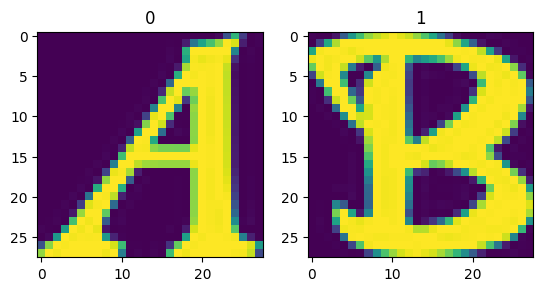

In [13]:
inds = np.random.randint(len(full_dataset), size=2)

for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.imshow(full_dataset[inds[i]][0].reshape([28, 28]))
    plt.title(str(full_dataset[inds[i]][1]))

#### To the DataLoader

In [14]:
train_loader = DataLoader(full_dataset, batch_size=8, shuffle=True, num_workers=1)

We can use dataloader as iterator by using iter() function.

In [19]:
train_iter = iter(train_loader)
print(type(train_iter))

<class 'torch.utils.data.dataloader._MultiProcessingDataLoaderIter'>


We can look at images and labels of batch size by extracting data `.next()` method.

In [21]:
images, labels = next(train_iter)

print("images shape on batch size = {}".format(images.size()))
print("labels shape on batch size = {}".format(labels.size()))

images shape on batch size = torch.Size([8, 28, 28, 1])
labels shape on batch size = torch.Size([8])


/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


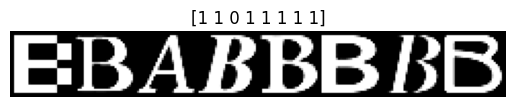

In [22]:
# make grid takes tensor as arg
# tensor : (batchsize, channels, height, width)
grid = torchvision.utils.make_grid(images.permute([0, 3, 1, 2]))

plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis("off")
plt.title(labels.numpy());

And now with transformations:

In [23]:
train_dataset_with_transform = DatasetMNIST(transform=torchvision.transforms.ToTensor())

Parsing...
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done


In [24]:
img, lab = train_dataset_with_transform.__getitem__(0)

print("image shape at the first row : {}".format(img.size()))

image shape at the first row : torch.Size([1, 28, 28])


In [25]:
train_loader_tr = DataLoader(train_dataset_with_transform, batch_size=8, shuffle=True)

train_iter_tr = iter(train_loader_tr)
print(type(train_iter_tr))

images, labels = next(train_iter_tr)

print("images shape on batch size = {}".format(images.size()))
print("labels shape on batch size = {}".format(labels.size()))

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>
images shape on batch size = torch.Size([8, 1, 28, 28])
labels shape on batch size = torch.Size([8])


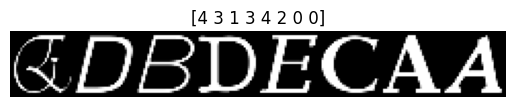

In [26]:
grid = torchvision.utils.make_grid(images)

plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis("off")
plt.title(labels.numpy());

### Composing several transformations

If you want to take data augmentation, you have to make List using `torchvision.transforms.Compose`

```
class Compose(object):
    """Composes several transforms together.
    Args:
        transforms (list of ``Transform`` objects): list of transforms to compose.
    Example:
        >>> transforms.Compose([
        >>>     transforms.CenterCrop(10),
        >>>     transforms.ToTensor(),
        >>> ])
    """

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img):
        for t in self.transforms:
            img = t(img)
        return img

    def __repr__(self):
        format_string = self.__class__.__name__ + '('
        for t in self.transforms:
            format_string += '\n'
            format_string += '    {0}'.format(t)
        format_string += '\n)'
        return format_string
```


this function can convert some image by order within `__call__` method.

In [27]:
class Flatten:
    def __call__(self, pic):
        return pic.flatten()

    def __repr__(self):
        return self.__class__.__name__ + "()"

In [28]:
a = Flatten()

In [29]:
a(img).shape

torch.Size([784])

In [30]:
new_transform = torchvision.transforms.Compose([
#     torchvision.transforms.CenterCrop(),
#     torchvision.transforms.Resize((640, 460)),
    torchvision.transforms.ToTensor(),
    Flatten(),
])

# Putting all together

In [31]:
import time

from IPython.display import clear_output

In [32]:
# use GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [33]:
def subset_ind(dataset, ratio: float):
    #     return ### YOUR CODE HERE
    return np.random.choice(len(dataset), size=int(ratio * len(dataset)), replace=False)

In [34]:
dataset = DatasetMNIST(
    "./notMNIST_small",
#     'AB',
    transform=new_transform,
)

shrink_inds = subset_ind(dataset, 0.2)
dataset = Subset(dataset, shrink_inds)

print(f"\n\n dataset size: {len(dataset)}, labels: {np.unique(dataset.dataset.labels)}")

Parsing...
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done


 dataset size: 3744, labels: [0 1 2 3 4 5 6 7 8 9]


In [35]:
val_size = 0.2
val_inds = subset_ind(dataset, val_size)

train_dataset = Subset(dataset, [i for i in range(len(dataset)) if i not in val_inds])
val_dataset = Subset(dataset, val_inds)

print(f"  training size: {len(train_dataset)}\nvalidation size: {len(val_dataset)}")

  training size: 2996
validation size: 748


In [36]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [37]:
train_iter = iter(train_loader)
print(type(train_iter))

images, labels = next(train_iter)

print("images shape on batch size = {}".format(images.size()))
print("labels shape on batch size = {}".format(labels.size()))

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>
images shape on batch size = torch.Size([32, 784])
labels shape on batch size = torch.Size([32])


In [38]:
loss_func = nn.CrossEntropyLoss()

In [39]:
default_dtype = torch.float32

In [40]:
# create network again just in case
model = nn.Sequential(
    nn.Linear(784, 10),
    nn.Sigmoid(),
)
model.to(device, default_dtype)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [41]:
preds = torch.rand(3, 10)
preds

tensor([[0.4117, 0.5414, 0.0689, 0.3758, 0.7880, 0.7943, 0.7119, 0.8921, 0.1482,
         0.1648],
        [0.4887, 0.7524, 0.8615, 0.3111, 0.7879, 0.8077, 0.3627, 0.8663, 0.1452,
         0.4914],
        [0.9311, 0.6039, 0.5714, 0.1210, 0.0760, 0.9263, 0.6220, 0.5141, 0.3315,
         0.8925]])

In [42]:
vals, inds = preds.max(-1)

In [43]:
inds

tensor([7, 7, 0])

In [44]:
vals

tensor([0.8921, 0.8663, 0.9311])

In [45]:
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int, device=device):
    """
    model: нейросеть для обучения,
    train_loader, val_loader: загрузчики данных
    loss_fn: целевая метрика (которую будем оптимизировать)
    opt: оптимизатор (обновляет веса нейросети)
    n_epochs: кол-во эпох, полных проходов датасета
    """
    train_loss = []
    val_loss = []
    val_accuracy = []

    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time.time()

        model.train(True)  # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            # move data to target device
            ### YOUR CODE HERE
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            ### YOUR CODE HERE
            preds = model(X_batch)
            loss = loss_fn(preds, y_batch)

            opt.zero_grad()
            loss.backward()

            opt.step()

            ep_train_loss.append(loss.item())

        model.train(False)  # disable dropout / use averages for batch_norm
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                # move data to target device
                # YOUR CODE HERE
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                preds = model(X_batch)
                loss = loss_fn(preds, y_batch)

                # compute predictions
                # YOUR CODE HERE
                ep_val_loss.append(loss.item())  # YOUR CODE HERE
                y_pred = preds.max(-1)[1]  # YOUR CODE HERE
                ep_val_accuracy.append((y_pred == y_batch).to(default_dtype).mean().item())  # YOUR CODE HERE

        # print the results for this epoch:
        print(f"Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s")

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))

        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")

    return train_loss, val_loss, val_accuracy

In [46]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(
    model, train_loader, val_loader, loss_func, opt, n_epochs
)

Epoch 1 of 30 took 0.749s
	  training loss: 1.840922
	validation loss: 1.710348
	validation accuracy: 0.825
Epoch 2 of 30 took 0.357s
	  training loss: 1.689865
	validation loss: 1.666413
	validation accuracy: 0.854
Epoch 3 of 30 took 0.356s
	  training loss: 1.653763
	validation loss: 1.647314
	validation accuracy: 0.862
Epoch 4 of 30 took 0.431s
	  training loss: 1.635917
	validation loss: 1.641264
	validation accuracy: 0.860
Epoch 5 of 30 took 0.267s
	  training loss: 1.623798
	validation loss: 1.631127
	validation accuracy: 0.866
Epoch 6 of 30 took 0.441s
	  training loss: 1.615133
	validation loss: 1.628189
	validation accuracy: 0.859
Epoch 7 of 30 took 0.337s
	  training loss: 1.608626
	validation loss: 1.625290
	validation accuracy: 0.862
Epoch 8 of 30 took 0.142s
	  training loss: 1.601550
	validation loss: 1.623145
	validation accuracy: 0.860
Epoch 9 of 30 took 0.144s
	  training loss: 1.597576
	validation loss: 1.620103
	validation accuracy: 0.863
Epoch 10 of 30 took 0.140s
	

In [48]:
def plot_train_process(train_loss, val_loss, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title("Loss")
    axes[0].plot(train_loss, label="train")
    axes[0].plot(val_loss, label="validation")
    axes[0].legend()

    axes[1].set_title("Validation accuracy")
    axes[1].plot(val_accuracy)

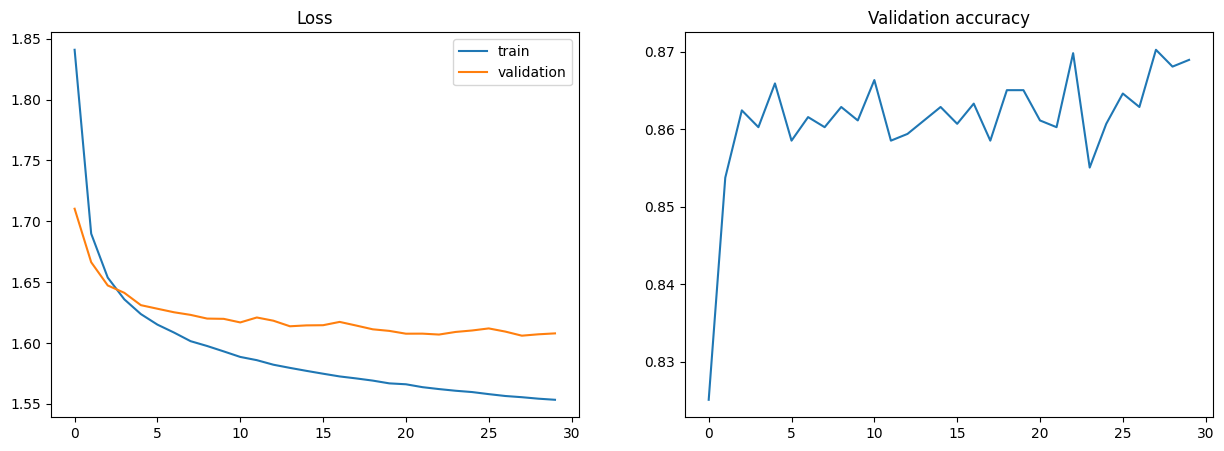

In [49]:
plot_train_process(train_loss, val_loss, val_accuracy)

## Real network

In [50]:
# create network again just in case
model = nn.Sequential(
    nn.Linear(784, 500),
    nn.ReLU(),
    nn.Linear(500, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
    nn.Sigmoid(),
)
model.to(device, torch.float32)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [51]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(
    model, train_loader, val_loader, loss_func, opt, n_epochs
)

Epoch 1 of 30 took 0.766s
	  training loss: 1.700269
	validation loss: 1.605197
	validation accuracy: 0.830
Epoch 2 of 30 took 0.770s
	  training loss: 1.579127
	validation loss: 1.581594
	validation accuracy: 0.874
Epoch 3 of 30 took 0.608s
	  training loss: 1.549172
	validation loss: 1.571452
	validation accuracy: 0.864
Epoch 4 of 30 took 0.530s
	  training loss: 1.535271
	validation loss: 1.559219
	validation accuracy: 0.885
Epoch 5 of 30 took 0.526s
	  training loss: 1.524876
	validation loss: 1.564582
	validation accuracy: 0.887
Epoch 6 of 30 took 0.552s
	  training loss: 1.516363
	validation loss: 1.563134
	validation accuracy: 0.885
Epoch 7 of 30 took 0.539s
	  training loss: 1.513966
	validation loss: 1.568321
	validation accuracy: 0.867
Epoch 8 of 30 took 0.552s
	  training loss: 1.512444
	validation loss: 1.571080
	validation accuracy: 0.877
Epoch 9 of 30 took 0.555s
	  training loss: 1.511025
	validation loss: 1.564088
	validation accuracy: 0.895
Epoch 10 of 30 took 0.570s
	

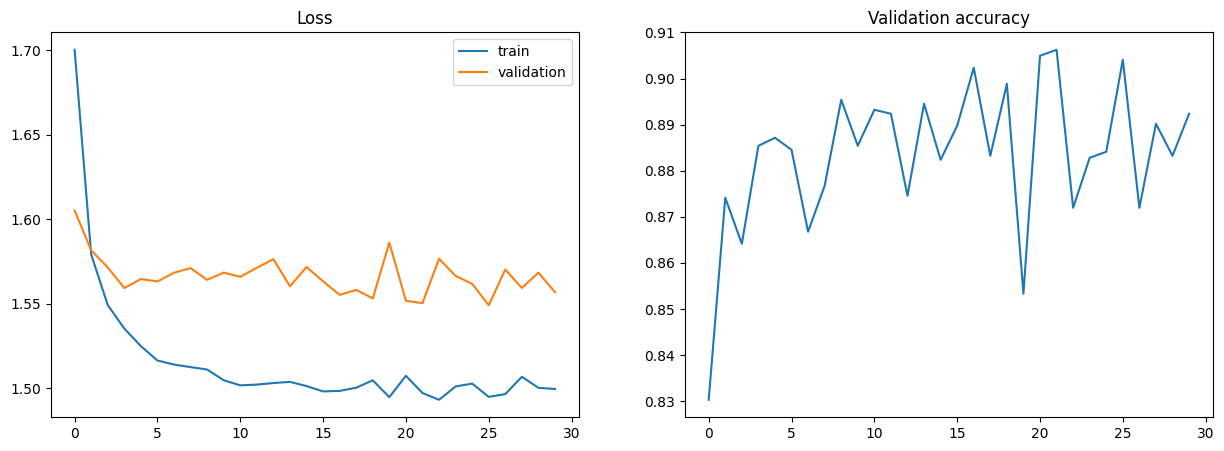

In [52]:
plot_train_process(train_loss, val_loss, val_accuracy)

In [53]:
import torchsummary

In [ ]:
28**2

784

In [54]:
torchsummary.summary(model, (784,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 500]         392,500
              ReLU-2                  [-1, 500]               0
            Linear-3                  [-1, 200]         100,200
              ReLU-4                  [-1, 200]               0
            Linear-5                   [-1, 10]           2,010
           Sigmoid-6                   [-1, 10]               0
Total params: 494,710
Trainable params: 494,710
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.89
Estimated Total Size (MB): 1.90
----------------------------------------------------------------


## Overfit!!!

In [57]:
# create network again just in case
model = nn.Sequential(
    nn.Linear(784, 600),
    nn.ReLU(),
    nn.Linear(600, 500),
    nn.ReLU(),
    nn.Linear(500, 500),
    nn.ReLU(),
    nn.Linear(500, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
    nn.Sigmoid(),
)
model.to(device, torch.float32)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [58]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(
    model, train_loader, val_loader, loss_func, opt, n_epochs
)

Epoch 1 of 30 took 1.643s
	  training loss: 1.739730
	validation loss: 1.636110
	validation accuracy: 0.769
Epoch 2 of 30 took 2.779s
	  training loss: 1.620296
	validation loss: 1.616598
	validation accuracy: 0.810
Epoch 3 of 30 took 1.611s
	  training loss: 1.596463
	validation loss: 1.589790
	validation accuracy: 0.860
Epoch 4 of 30 took 1.282s
	  training loss: 1.584893
	validation loss: 1.671425
	validation accuracy: 0.707
Epoch 5 of 30 took 1.262s
	  training loss: 1.614155
	validation loss: 1.642146
	validation accuracy: 0.728
Epoch 6 of 30 took 1.634s
	  training loss: 1.613735
	validation loss: 1.597795
	validation accuracy: 0.788
Epoch 7 of 30 took 1.927s
	  training loss: 1.607144
	validation loss: 1.685761
	validation accuracy: 0.661
Epoch 8 of 30 took 2.071s
	  training loss: 1.634050
	validation loss: 1.686535
	validation accuracy: 0.569
Epoch 9 of 30 took 2.686s
	  training loss: 1.647720
	validation loss: 1.656228
	validation accuracy: 0.736
Epoch 10 of 30 took 2.958s
	

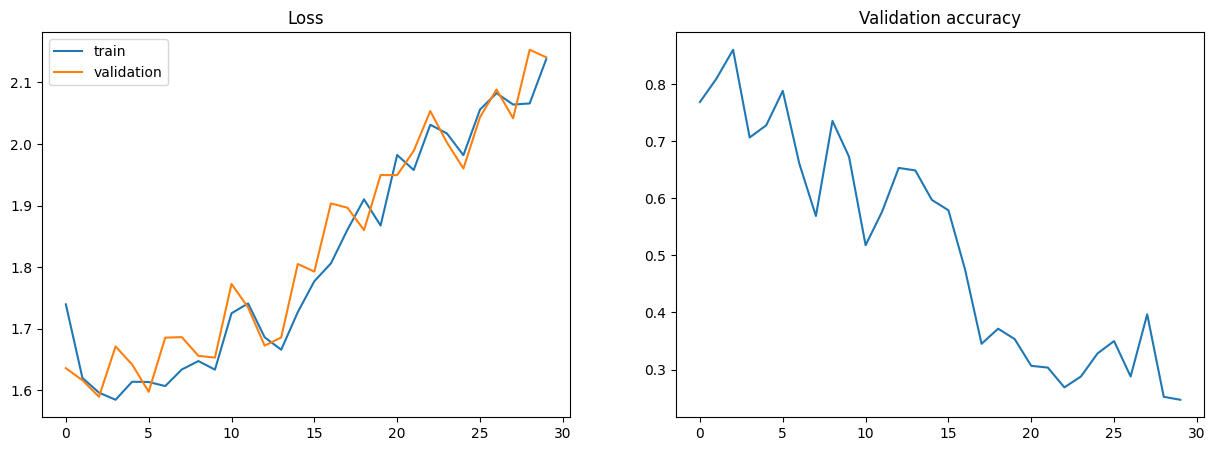

In [59]:
plot_train_process(train_loss, val_loss, val_accuracy)

## Your turn
Try to add some additional transformations (e.g. random crop, rotation etc.) and train your model!

### Dropout try

In [60]:
model = nn.Sequential(
    nn.Linear(784, 600),
    nn.ReLU(),
    nn.Linear(600, 500),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.Linear(500, 500),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.Linear(500, 200),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.Linear(200, 10),
    nn.Sigmoid(),
)
model.to(device, torch.float32)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [61]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(
    model, train_loader, val_loader, loss_func, opt, n_epochs
)

Epoch 1 of 30 took 1.649s
	  training loss: 1.755851
	validation loss: 1.620018
	validation accuracy: 0.733
Epoch 2 of 30 took 1.556s
	  training loss: 1.618606
	validation loss: 1.634090
	validation accuracy: 0.758
Epoch 3 of 30 took 1.435s
	  training loss: 1.593051
	validation loss: 1.606528
	validation accuracy: 0.790
Epoch 4 of 30 took 1.240s
	  training loss: 1.587958
	validation loss: 1.595678
	validation accuracy: 0.782
Epoch 5 of 30 took 1.513s
	  training loss: 1.599070
	validation loss: 1.626027
	validation accuracy: 0.762
Epoch 6 of 30 took 1.460s
	  training loss: 1.584986
	validation loss: 1.587374
	validation accuracy: 0.798
Epoch 7 of 30 took 1.774s
	  training loss: 1.580938
	validation loss: 1.567855
	validation accuracy: 0.868
Epoch 8 of 30 took 2.622s
	  training loss: 1.571936
	validation loss: 1.600437
	validation accuracy: 0.840
Epoch 9 of 30 took 2.436s
	  training loss: 1.600160
	validation loss: 1.603999
	validation accuracy: 0.848
Epoch 10 of 30 took 2.465s
	

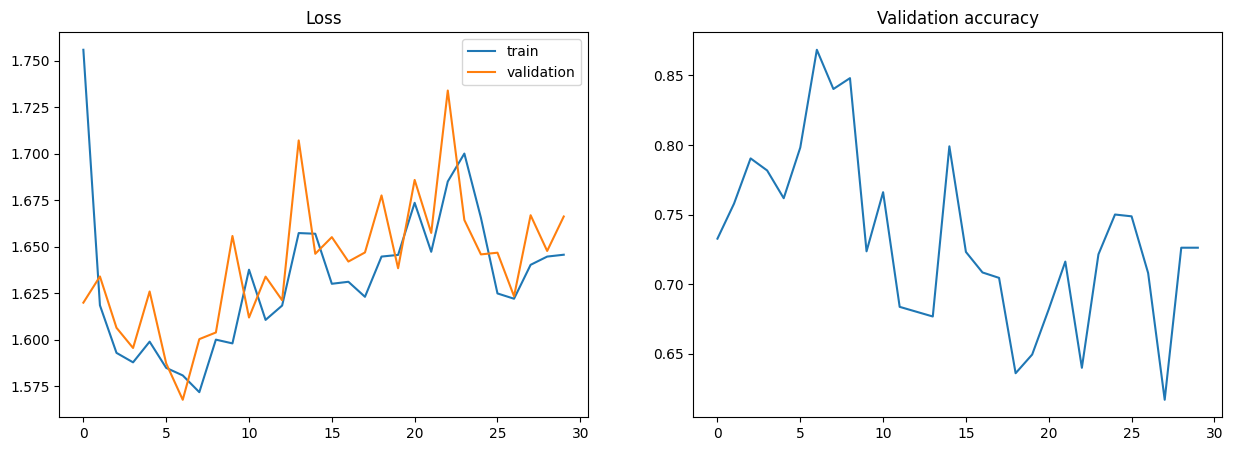

In [62]:
plot_train_process(train_loss, val_loss, val_accuracy)

### Batchnorm try

In [69]:
model = nn.Sequential(
    nn.Linear(784, 600),
    nn.BatchNorm1d(600),
    nn.ReLU(),
    nn.Linear(600, 500),
    nn.ReLU(),
    nn.Linear(500, 500),
    nn.ReLU(),
    nn.Linear(500, 200),
    nn.BatchNorm1d(200),
    nn.ReLU(),
    nn.Linear(200, 10),
    nn.Sigmoid(),
)
model.to(device, torch.float32)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [72]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(
    model, train_loader, val_loader, loss_func, opt, n_epochs
)

Epoch 1 of 30 took 2.070s
	  training loss: 1.481773
	validation loss: 1.559223
	validation accuracy: 0.893
Epoch 2 of 30 took 2.559s
	  training loss: 1.481494
	validation loss: 1.560744
	validation accuracy: 0.891
Epoch 3 of 30 took 2.702s
	  training loss: 1.482524
	validation loss: 1.551629
	validation accuracy: 0.900
Epoch 4 of 30 took 2.910s
	  training loss: 1.484345
	validation loss: 1.549360
	validation accuracy: 0.908
Epoch 5 of 30 took 4.624s
	  training loss: 1.482298
	validation loss: 1.551007
	validation accuracy: 0.888
Epoch 6 of 30 took 4.371s
	  training loss: 1.479314
	validation loss: 1.559869
	validation accuracy: 0.892
Epoch 7 of 30 took 2.816s
	  training loss: 1.484003
	validation loss: 1.556344
	validation accuracy: 0.897
Epoch 8 of 30 took 1.689s
	  training loss: 1.479749
	validation loss: 1.555040
	validation accuracy: 0.894
Epoch 9 of 30 took 1.683s
	  training loss: 1.478258
	validation loss: 1.551268
	validation accuracy: 0.900
Epoch 10 of 30 took 1.697s
	

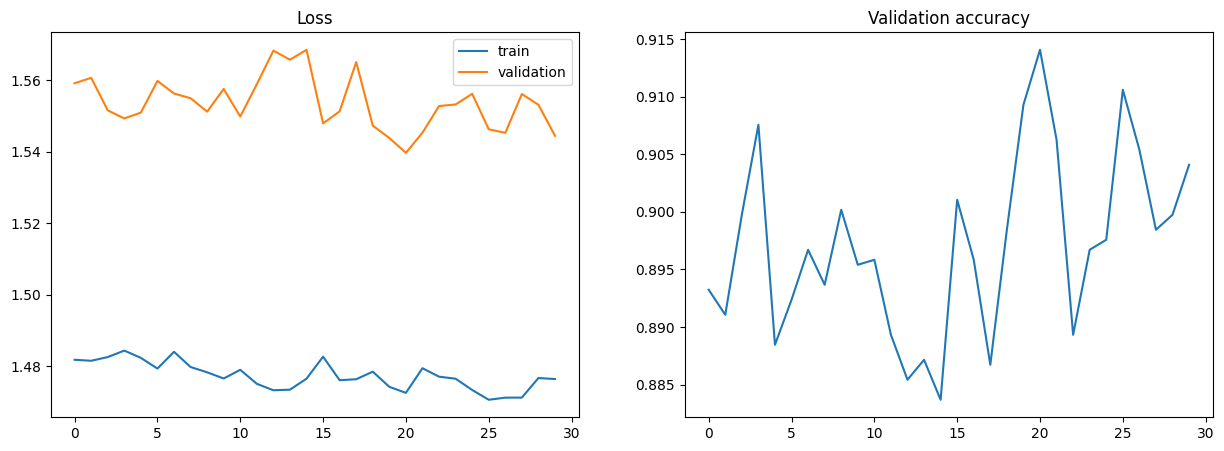

In [73]:
plot_train_process(train_loss, val_loss, val_accuracy)

### All together

In [80]:
model = nn.Sequential(
    nn.Linear(784, 600),
    nn.BatchNorm1d(600),
    nn.ReLU(),
    nn.Linear(600, 500),
    nn.Dropout(0.5),
    nn.ReLU(),
    nn.Linear(500, 500),
    nn.BatchNorm1d(500),
    nn.ReLU(),
    nn.Linear(500, 200),
    nn.BatchNorm1d(200),
    nn.Dropout(0.5),
    nn.ReLU(),
    nn.Linear(200, 10),
    nn.Dropout(0.5),
    nn.Sigmoid(),
)
model.to(device, torch.float32)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [81]:
n_epochs = 100

train_loss, val_loss, val_accuracy = train_model(
    model, train_loader, val_loader, loss_func, opt, n_epochs
)

Epoch 1 of 100 took 1.449s
	  training loss: 2.074866
	validation loss: 1.755633
	validation accuracy: 0.839
Epoch 2 of 100 took 1.744s
	  training loss: 1.992488
	validation loss: 1.673429
	validation accuracy: 0.863
Epoch 3 of 100 took 1.697s
	  training loss: 1.975997
	validation loss: 1.644470
	validation accuracy: 0.878
Epoch 4 of 100 took 1.518s
	  training loss: 1.970707
	validation loss: 1.623255
	validation accuracy: 0.883
Epoch 5 of 100 took 1.457s
	  training loss: 1.959265
	validation loss: 1.610108
	validation accuracy: 0.875
Epoch 6 of 100 took 1.242s
	  training loss: 1.950652
	validation loss: 1.613670
	validation accuracy: 0.867
Epoch 7 of 100 took 1.235s
	  training loss: 1.944062
	validation loss: 1.610741
	validation accuracy: 0.865
Epoch 8 of 100 took 1.534s
	  training loss: 1.944660
	validation loss: 1.596994
	validation accuracy: 0.877
Epoch 9 of 100 took 1.668s
	  training loss: 1.943593
	validation loss: 1.584682
	validation accuracy: 0.890
Epoch 10 of 100 too

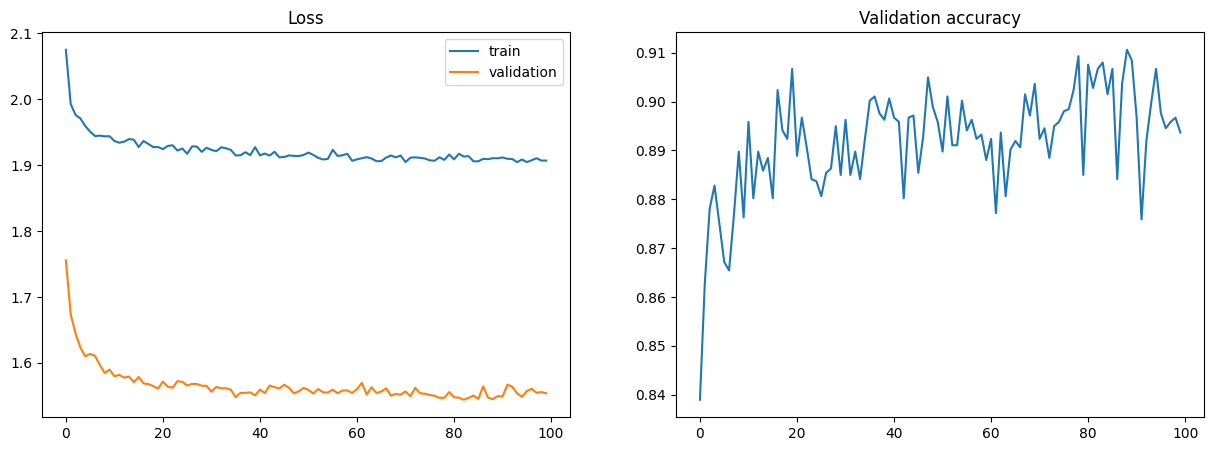

In [82]:
plot_train_process(train_loss, val_loss, val_accuracy)